In [5]:
# @title Default title text
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#for data preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize,word_tokenize
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
#Model Building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
##Importing the Dataset
from google.colab import drive
drive.mount("/content/drive") # Changed the mount point to an existing directory
data=pd.read_csv("/content/drive/My Drive/Colab Notebooks/spam.csv",encoding='latin1') # Updated path to reflect file location in Google Drive
data.sample(5)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
3312,ham,"Huh... Hyde park not in mel ah, opps, got conf...",NaN,NaN,NaN
890,ham,Why do you ask princess?,NaN,NaN,NaN
508,ham,What's the significance?,NaN,NaN,NaN
1650,ham,I dont have any of your file in my bag..i was ...,NaN,NaN,NaN
4468,ham,"Nothing, smsing u n xy lor. Sorry lor da guys ...",NaN,NaN,NaN


In [6]:
data.shape
data.drop(columns=["Unnamed: 2","Unnamed: 3","Unnamed: 4"],inplace=True)
data.rename(columns={'v1':'result','v2':'emails'},inplace=True)
data
data.isnull().sum()
data.duplicated().sum()
data=data.drop_duplicates(keep='first')
data.shape
data.head(5)

,result,emails
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


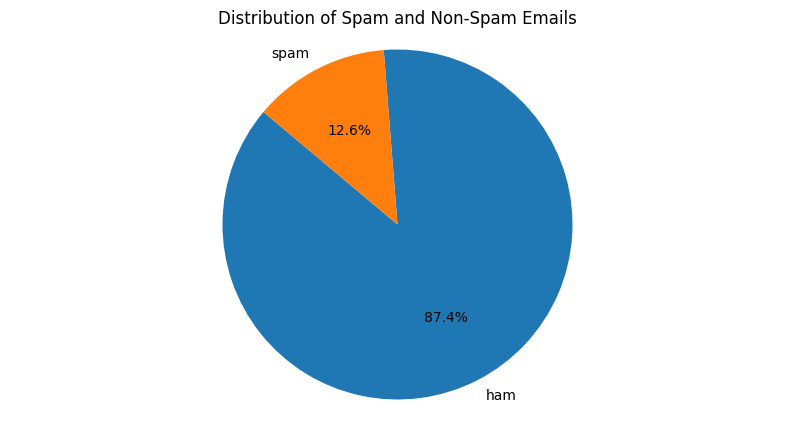

In [7]:
data['result'].value_counts()
#plotting
plt.figure(figsize=(10,5))
plt.pie(data['result'].value_counts(),labels=data['result'].value_counts().index,autopct='%1.1f%%',startangle=140)
plt.title('Distribution of Spam and Non-Spam Emails')
plt.axis('equal')
plt.show()

Average Length of Spam Emails:  137.89127105666157
Average Length of Ham Emails:  70.45925597874225


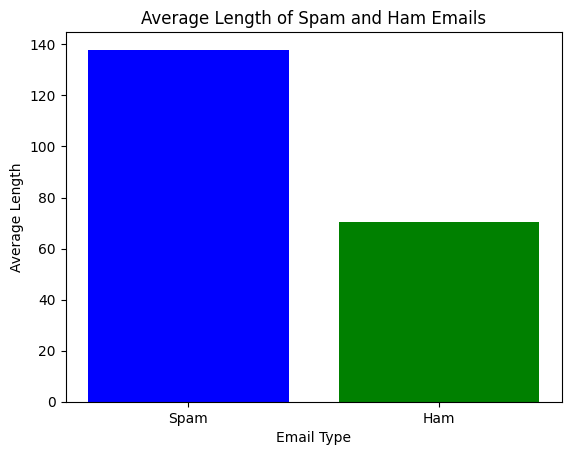

In [8]:
data['Length']=data['emails'].apply(len)
data['num_words']=data['emails'].apply(word_tokenize).apply(len)
data['num_sentence']=data['emails'].apply(sent_tokenize).apply(len)
data.head(2)
avg_length_spam=data[data['result']=='spam']['Length'].mean()
avg_length_ham=data[data['result']=='ham']['Length'].mean()
#plotting
print("Average Length of Spam Emails: ",avg_length_spam)
print("Average Length of Ham Emails: ",avg_length_ham)
plt.bar(['Spam','Ham'],[avg_length_spam,avg_length_ham],color=['Blue','green'])
plt.xlabel('Email Type')
plt.ylabel('Average Length')
plt.title('Average Length of Spam and Ham Emails')
plt.show()


avg_word_spam=data[data['result']=='spam']['num_words'].mean()
avg_word_ham=data[data['result']=='ham']['num_words'].mean()
print("Average Number of Words in Spam Emails: ",avg_word_spam)
print("Average Number of Words in Ham Emails: ",avg_word_ham)
#plotting the graph
plt.bar(['Spam','Ham'],[avg_word_spam,avg_word_ham],color=['Blue','green'])
plt.xlabel('Email Type')
plt.ylabel('Average Number of Words')
plt.title('Average Number of Words in Spam and Ham Emails')
plt.show()


Average Number of Sentences in Spam Emails:  2.970903522205207
Average Number of Sentences in Ham Emails:  1.8201948627103632


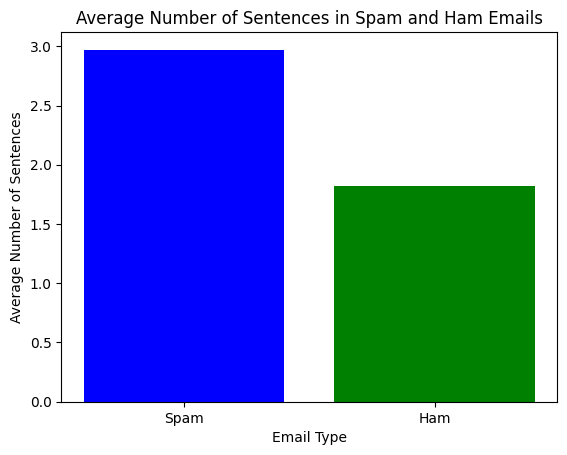

In [9]:
#avg sentencing
avg_sentence_spam=data[data['result']=='spam']['num_sentence'].mean()
avg_sentence_ham=data[data['result']=='ham']['num_sentence'].mean()
print("Average Number of Sentences in Spam Emails: ",avg_sentence_spam)
print("Average Number of Sentences in Ham Emails: ",avg_sentence_ham)
#plotting the graph
plt.bar(['Spam','Ham'],[avg_sentence_spam,avg_sentence_ham],color=['Blue','green'])
plt.xlabel('Email Type')
plt.ylabel('Average Number of Sentences')
plt.title('Average Number of Sentences in Spam and Ham Emails')
plt.show()

Correlation coefficient between Length and Spam:  0.38471706671430717


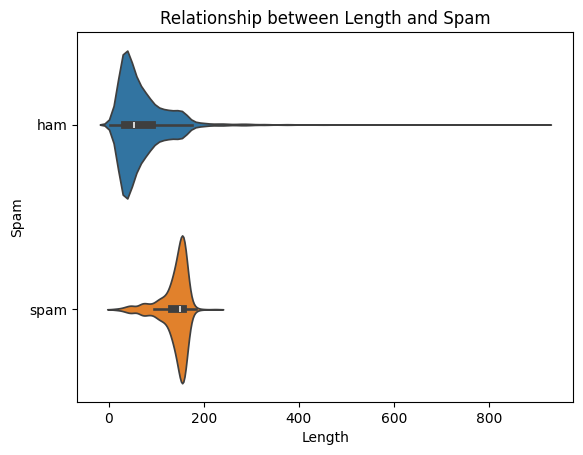

In [10]:
#Relationship between Length and Spam
correlation=data['Length'].corr((data['result']=='spam').astype(int))
print("Correlation coefficient between Length and Spam: ",correlation)
#plotting the graph
sns.violinplot(x='Length',y='result',hue='result',data=data)
plt.xlabel('Length')
plt.ylabel('Spam')
plt.title('Relationship between Length and Spam')
plt.show()

The Relationship between Features are                  Length  num_words  num_sentence
Length        1.000000   0.965760      0.624139
num_words     0.965760   1.000000      0.679971
num_sentence  0.624139   0.679971      1.000000


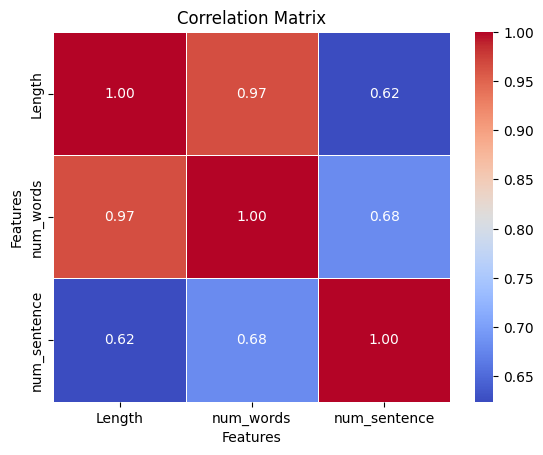

In [11]:
#Relationship between Features
correlation_matrix=data[['Length','num_words','num_sentence']].corr()
print("The Relationship between Features are ",correlation_matrix)
#Visualize the correlation matrix using a heatmap
sns.heatmap(correlation_matrix,annot=True,cmap='coolwarm',fmt=".2f",linewidths=0.5)
plt.title('Correlation Matrix')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [14]:

data['transform_text']= data['emails'].str.lower()
#Tokenization
data['transform_text']= data['transform_text'].apply(word_tokenize)
#Removing special characters
data['transform_text']= data['transform_text'].apply(lambda x: [re.sub(r'[^a-zA-Z0-9\s]','',word) for word in x])
#Removing stop words and punctuation
stop_words=set(stopwords.words('english'))
data['transform_text']= data['transform_text'].apply(lambda x: [word for word in x if word not in stop_words and word not in string.punctuation])
#stemming
#stemming
ps=PorterStemmer()
data['transform_text']= data['transform_text'].apply(lambda x:[ps.stem(word) for word in x]) # Use 'transform_text' here
#convert the preprocessed text back to string
data['transform_text']= data['transform_text'].apply(lambda x: ' '.join(x))
#Display the preprocessed data
print(data[['emails','transform_text']].head())

                                              emails  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                      transform_text  
0  go jurong point crazi avail bugi n great world...  
1                              ok lar joke wif u oni  
2  free entri 2 wkli comp win fa cup final tkt 21...  
3                u dun say earli hor u c alreadi say  
4            nah nt think goe usf live around though  


Top 10 Most Common Words in Spam Emails: 
call:321 occurences
free:191 occurences
2:157 occurences
txt:141 occurences
u:135 occurences
text:122 occurences
ur:119 occurences
mobil:114 occurences
stop:106 occurences
repli:103 occurences


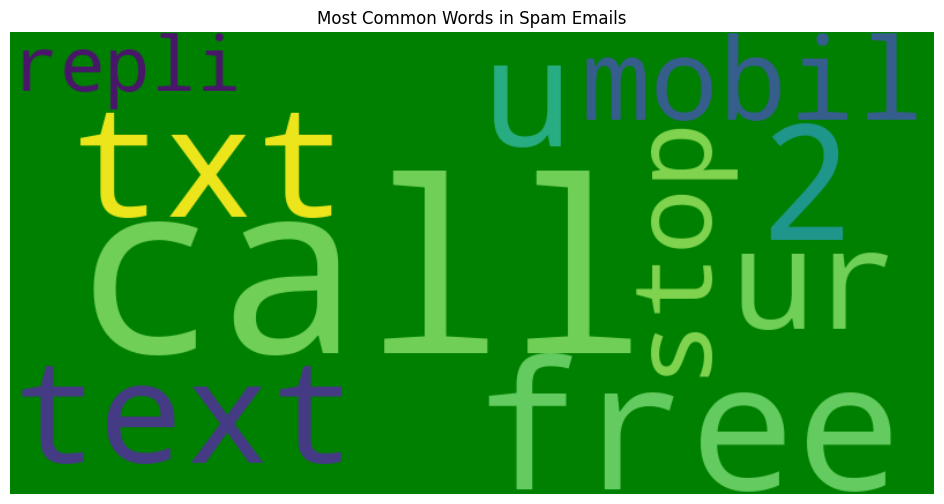

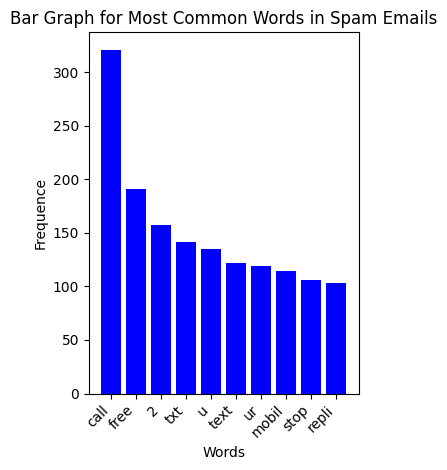

In [17]:
spam_emails=data[data['result']=='spam']['transform_text']
#tokenize the text in spam emails
spam_words=' '.join(spam_emails).split()
#count occurences of each word
word_counts=Counter(spam_words)
#Find the most commone words
most_common_words=word_counts.most_common(10)
print("Top 10 Most Common Words in Spam Emails: ")
for word,count in most_common_words:
  print(f"{word}:{count} occurences")
wordcloud=WordCloud(width=800,height=400,background_color='green').generate_from_frequencies(dict(most_common_words))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.title('Most Common Words in Spam Emails')
plt.axis('off')
plt.show()
plt.subplot(1,2,2)
words, counts=zip(*most_common_words)
plt.bar(words,counts,color='blue')
plt.title('Bar Graph for Most Common Words in Spam Emails')
plt.xlabel('Words')
plt.ylabel('Frequence')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [18]:
encoder=LabelEncoder()
data['result']=encoder.fit_transform(data['result'])
data.sample(2)
#data splitting and vectorization
tfidf=TfidfVectorizer(max_features=3000)
x=tfidf.fit_transform(data['transform_text']).toarray()
y=data['result']
X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [19]:
svc_classifier=SVC()
svc_classifier.fit(X_train,y_train)
y_pred_svc=svc_classifier.predict(X_test)
accuracy_svc=accuracy_score(y_test,y_pred_svc)
print(f"SVM Accuracy:{accuracy_svc:.2f}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_svc))
print("Precision Score :",precision_score(y_test,y_pred_svc))

SVM Accuracy:0.98
confusion Matrix : [[889   0]
 [ 25 120]]
Precision Score : 1.0


In [20]:
#Random Forest Classifier
rf_classifier=RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
y_pred_rf=rf_classifier.predict(X_test)
accuracy_rf=accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy:{accuracy_rf:.2f}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_rf))
print("Precision Score :",precision_score(y_test,y_pred_rf))

Random Forest Accuracy:0.98
confusion Matrix : [[888   1]
 [ 23 122]]
Precision Score : 0.991869918699187


In [21]:
#Naive Bayes classifier
nb_classifier=MultinomialNB()
nb_classifier.fit(X_train,y_train)
y_pred_nb=nb_classifier.predict(X_test)
accuracy_nb=accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy:{accuracy_nb:.2f}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_nb))
print("Precision Score :",precision_score(y_test,y_pred_nb))



Naive Bayes Accuracy:0.97
confusion Matrix : [[888   1]
 [ 25 120]]
Precision Score : 0.9917355371900827


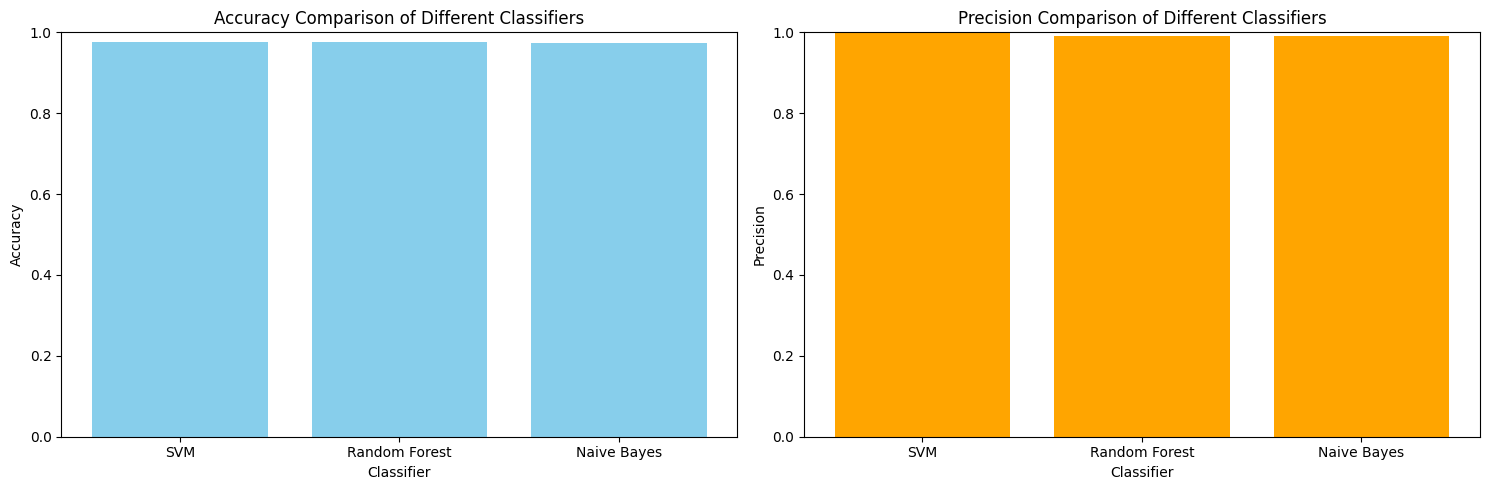

In [22]:
#chooosing the best classifier for email spam detection
#calculate precision scores for each classifier
precision_svc=precision_score(y_test, y_pred_svc)
precision_rf=precision_score(y_test, y_pred_rf)
precision_nb=precision_score(y_test, y_pred_nb)

#create lists to store accuracies and precision scores
classifiers=['SVM','Random Forest','Naive Bayes']
accuracies=[accuracy_svc,accuracy_rf,accuracy_nb]
precision_scores=[precision_svc,precision_rf,precision_nb]

#plot bar graph for accuracies and precision scores side by side
fig, axes = plt.subplots(1,2, figsize=(15,5))
#Plot bar graph for accuracies
axes[0].bar(classifiers,accuracies, color='skyblue')
axes[0].set_xlabel('Classifier')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison of Different Classifiers')
axes[0].set_ylim(0,1)
#plot bar graph for precision scores
axes[1].bar(classifiers,precision_scores, color='orange')
axes[1].set_xlabel('Classifier')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision Comparison of Different Classifiers')
axes[1].set_ylim(0,1)
plt.tight_layout()
plt.show()

In [23]:
#Model Prediction
#Predicting with new data
new_emails=[
    "Get a free iPhone now!",
    "Hey, how's it going?",
    "Congratulations! You've won a prize!",
    "Reminder: Meeting at 2 PM tomorrow."
]
#Convert new data into numerical vectors using the trained tfidf_vectorizer
new_X=tfidf.transform(new_emails)
new_X_dense=new_X.toarray()
#Use the trained SVM model to make predictions
svm_predictions=svc_classifier.predict(new_X_dense)
#Print the predictions
for email, prediction in zip(new_emails,svm_predictions):
  if prediction==1:
    print(f" '{email}' is Predicted as spam.")
  else:
    print(f"'{email}' is predicted as ham.")

'Get a free iPhone now!' is predicted as ham.
'Hey, how's it going?' is predicted as ham.
 'Congratulations! You've won a prize!' is Predicted as spam.
'Reminder: Meeting at 2 PM tomorrow.' is predicted as ham.


In [27]:
#User Input Data Predicton

def predict_email(email):
  #Convert email into numerical vector using the trained TF-IDF vectorizer
  email_vector=tfidf.transform([email])
  email_vector_dense=email_vector.toarray()
  #Use the trained SVM model to make predictions
  prediction=svc_classifier.predict(email_vector_dense)
  #print the prediction
  if prediction[0]==1:
    print("Email is predicted as spam.")
  else:
    print("Email is predicted as ham.")
#Get user input for email
user_email=input("Enter the email text: ")
#Predict  whether the input email is spam or not spam
predict_email(user_email)

Enter the email text:   **Subject:** Congratulations! You've Won a $1,000 Gift Card!  **From:** amazingoffers@example.com  **Body:**  Dear Customer,  Congratulations! You have been selected as the winner of a $1,000 gift card. This is a limited time offer just for you!  To claim your prize, simply click on the link below and fill out the required information:  [Claim Your $1,000 Gift Card Now!](http://spammywebsite.com)  Hurry, this offer expires soon!  Best Regards,   The Amazing Offers Team
Email is predicted as spam.
